<a href="https://colab.research.google.com/github/jsjj10002/FackVoiceClassfication/blob/main/asvsfoop%EC%9D%8C%EC%84%B1%EB%8D%B0%EC%9D%B4%ED%84%B0_%ED%83%90%EC%83%89.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!cd /content/

In [13]:
!gdown https://drive.google.com/uc?id=1WO2IUPox_FmVEEIWHn3_yDzgCjoH-pfz

Downloading...
From: https://drive.google.com/uc?id=1WO2IUPox_FmVEEIWHn3_yDzgCjoH-pfz
To: /content/solar-curve-424711-f6-daafd3601e73.json
100% 2.37k/2.37k [00:00<00:00, 8.63MB/s]


In [1]:
!curl -O https://dl.google.com/dl/cloudsdk/channels/rapid/downloads/google-cloud-sdk-367.0.0-linux-x86_64.tar.gz
!tar -xf google-cloud-sdk-367.0.0-linux-x86_64.tar.gz
!./google-cloud-sdk/install.sh


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 88.8M  100 88.8M    0     0  26.0M      0  0:00:03  0:00:03 --:--:-- 26.0M
Welcome to the Google Cloud SDK!
the installation to be inaccessible to users other than the root user.

To help improve the quality of this product, we collect anonymized usage data
and anonymized stacktraces when crashes are encountered; additional information
is available at <https://cloud.google.com/sdk/usage-statistics>. This data is
handled in accordance with our privacy policy
<https://cloud.google.com/terms/cloud-privacy-notice>. You may choose to opt in this
collection now (by choosing 'Y' at the below prompt), or at any time in the
future by running the following command:

    gcloud config set disable_usage_reporting false

Do you want to help improve the Google Cloud SDK (y/N)?  y


Your current Cloud SDK version is: 367.0.0
The latest avail

In [2]:
!gcloud init

Welcome! This command will take you through the configuration of gcloud.

Settings from your current configuration [default] are:
component_manager:
  disable_update_check: 'True'
compute:
  gce_metadata_read_timeout_sec: '0'

Pick configuration to use:
 [1] Re-initialize this configuration [default] with new settings 
 [2] Create a new configuration
Please enter your numeric choice:  1

Your current configuration has been set to: [default]

You can skip diagnostics next time by using the following flag:
  gcloud init --skip-diagnostics

Network diagnostic detects and fixes local network connection issues.
Reachability Check passed.
Network diagnostic passed (1/1 checks passed).

You must log in to continue. Would you like to log in (Y/n)?  Y


You are running on a Google Compute Engine virtual machine.
It is recommended that you use service accounts for authentication.

You can run:

  $ gcloud config set account `ACCOUNT`

to switch accounts if necessary.

Your credentials may be vis

In [4]:
!gcloud auth activate-service-account --key-file=/content/solar-curve-424711-f6-46d5c6fcd971.json

Activated service account credentials for: [data-889@solar-curve-424711-f6.iam.gserviceaccount.com]


In [17]:
!export GOOGLE_APPLICATION_CREDENTIALS="/content/solar-curve-424711-f6-46d5c6fcd971.json"

In [5]:
!pip install google-cloud-storage

In [14]:
!pip install ffmpeg-python

In [22]:
from google.colab import auth
auth.authenticate_user()

In [6]:
from google.cloud import storage
from io import BytesIO

def download_blob_as_string(bucket_name, source_blob_name):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    data = blob.download_as_string()
    return data

def read_blob_directly(bucket_name, source_blob_name):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    data = BytesIO()
    blob.download_to_file(data)
    data.seek(0)
    return data


In [23]:
# 인증 완료 후 클라이언트 객체 생성
import os
client = storage.Client()
credentials_path = os.environ.get('GOOGLE_APPLICATION_CREDENTIALS')
bucket_name = 'data-asv'
bucket = client.bucket(bucket_name)

In [30]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [27]:
def get_top_n_files_from_gcs(bucket_name, folder, top_n=3):
    blobs = bucket.list_blobs(prefix=folder)
    file_names = [blob.name for blob in blobs if blob.name.endswith('.flac')]
    return file_names[:top_n]

# 상위 3개의 오디오 파일명 불러오기
folder = 'LA/flac/'
audio_files = get_top_n_files_from_gcs(bucket_name, folder)

audio_files


['LA/flac/LA_E_1000349.flac',
 'LA/flac/LA_E_1000381.flac',
 'LA/flac/LA_E_1000479.flac']

In [31]:

import IPython.display as ipd
import io

def get_audio_from_gcs(bucket_name, file_path):
    blob = bucket.blob(file_path)
    audio_data = io.BytesIO()
    blob.download_to_file(audio_data)
    audio_data.seek(0)
    return audio_data

# 오디오 재생
for audio_file in audio_files:
    audio_data = get_audio_from_gcs(bucket_name, audio_file)
    y, sr = librosa.load(audio_data, sr=16000)
    ipd.display(ipd.Audio(data=y, rate=sr))


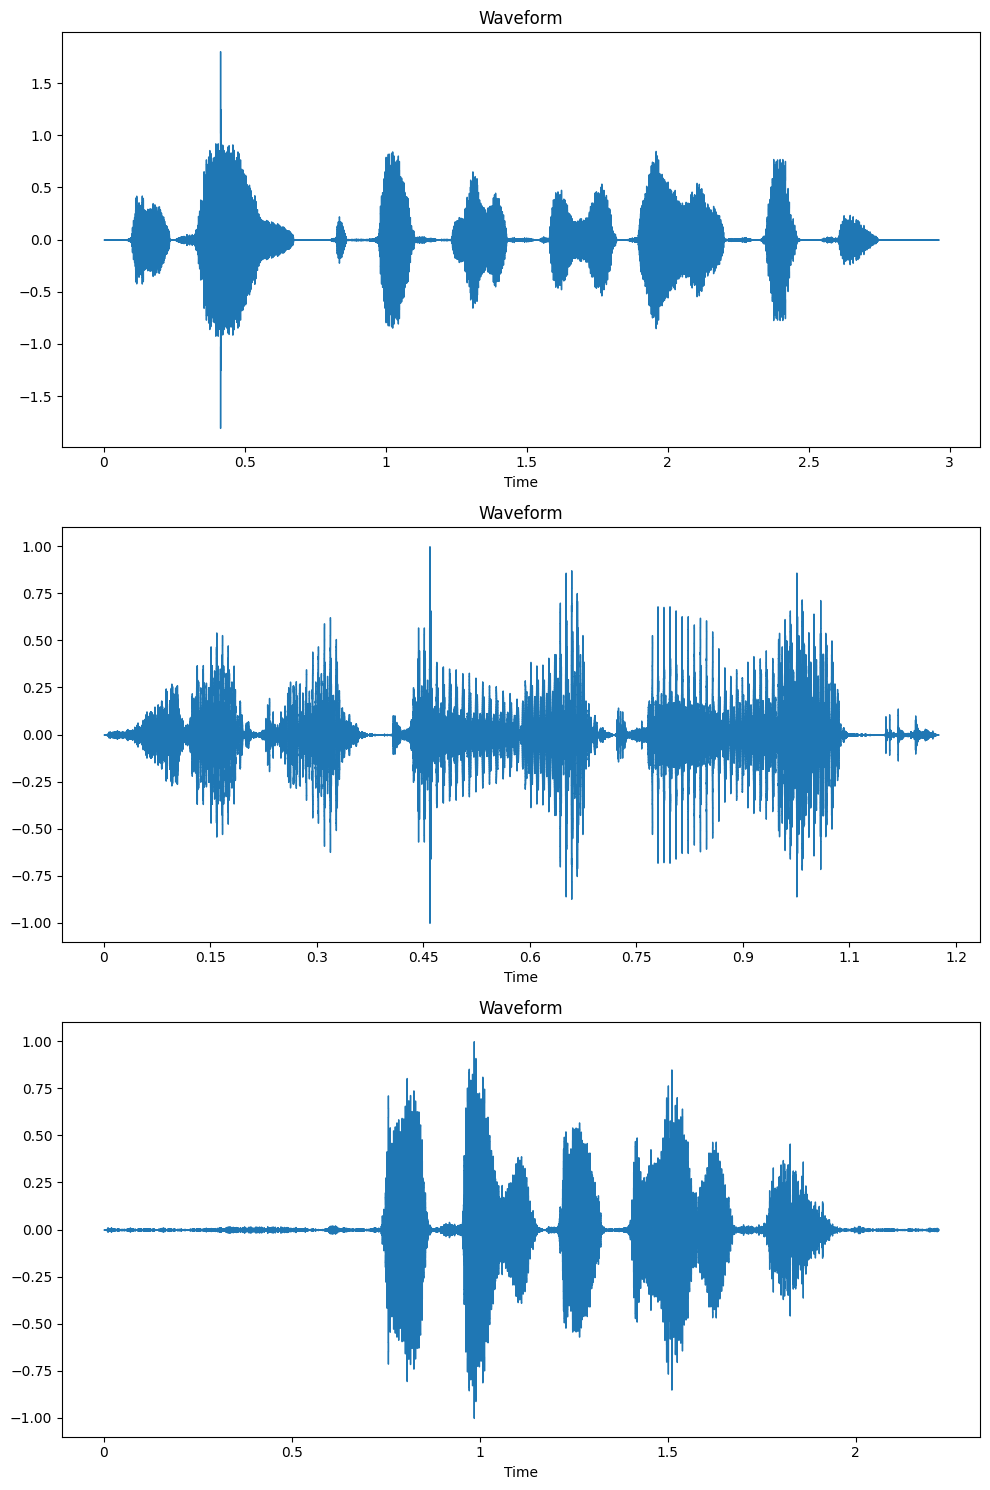

In [32]:
def plot_waveform(audio_data, sr, ax):
    y, _ = librosa.load(audio_data, sr=sr)
    librosa.display.waveshow(y, sr=sr, ax=ax)
    ax.set_title('Waveform')

fig, axs = plt.subplots(3, 1, figsize=(10, 15))

for i, audio_file in enumerate(audio_files):
    audio_data = get_audio_from_gcs(bucket_name, audio_file)
    plot_waveform(audio_data, sr=16000, ax=axs[i])

plt.tight_layout()
plt.show()


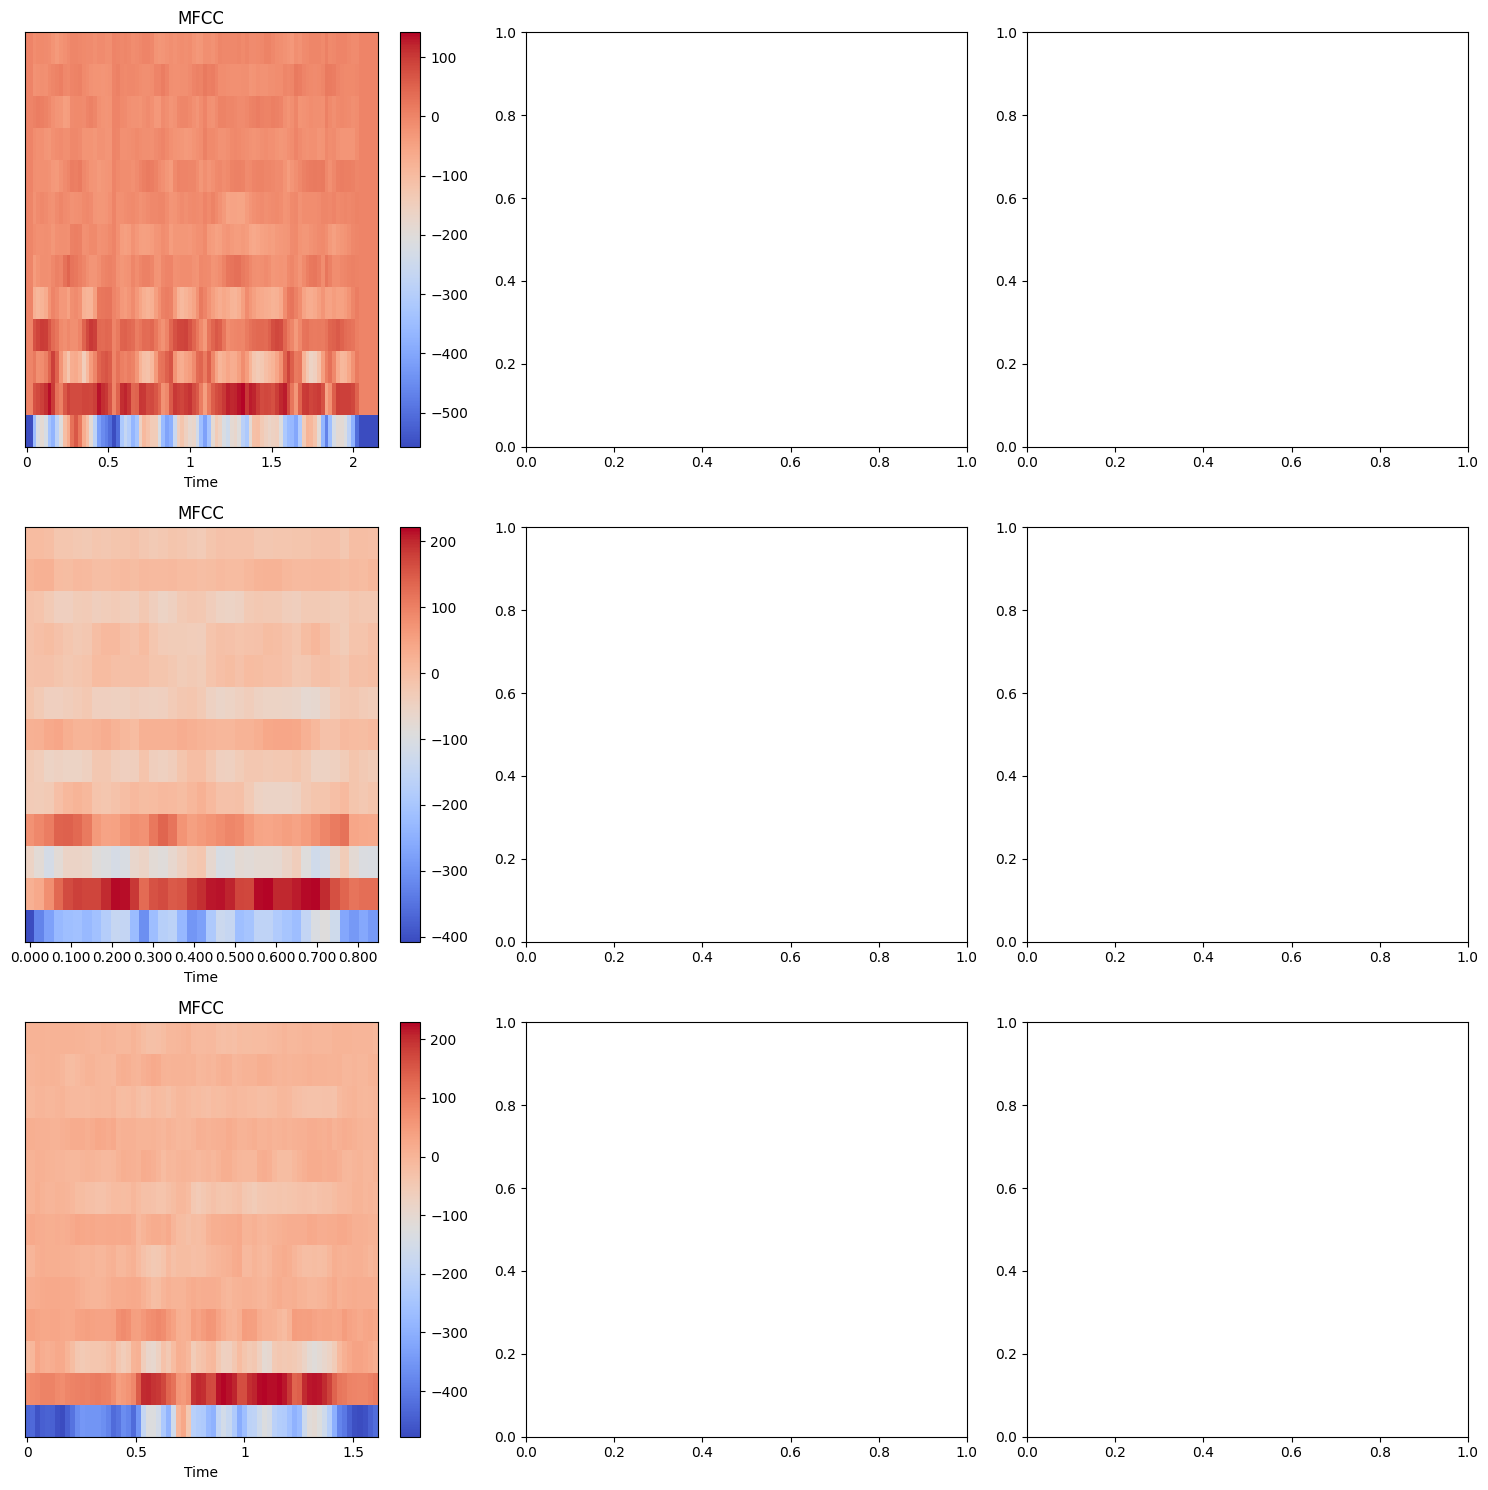

In [33]:
import numpy as np

def plot_features(feature, feature_name, ax):
    img = librosa.display.specshow(feature, x_axis='time', ax=ax)
    ax.set_title(feature_name)
    plt.colorbar(img, ax=ax)

fig, axs = plt.subplots(3, 3, figsize=(15, 15))

for i, audio_file in enumerate(audio_files):
    audio_data = get_audio_from_gcs(bucket_name, audio_file)
    y, sr = librosa.load(audio_data, sr=16000)

    # MFCC
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    plot_features(mfcc, 'MFCC', axs[i, 0])

    # CQCC: CQCC는 librosa에서 직접 제공하지 않으므로 별도의 구현이 필요합니다.
    # 여기서는 예제에서는 구현하지 않았지만, 실제 사용 시 CQCC 구현을 추가하세요.
    # plot_features(cqcc, 'CQCC', axs[i, 1])

    # LFCC: LFCC는 librosa에서 제공하지 않으므로 별도의 구현이 필요합니다.
    # 여기서는 예제에서는 구현하지 않았지만, 실제 사용 시 LFCC 구현을 추가하세요.
    # plot_features(lfcc, 'LFCC', axs[i, 2])

plt.tight_layout()
plt.show()
